## Import statements

In [1]:
import gc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

from sklearn.model_selection import train_test_split as tts

from sklearn.metrics import accuracy_score, precision_score, f1_score

from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
class Learner():

    def __init__(self, classes : tuple, num_estimators : tuple, max_depths : tuple, train_df : pd.DataFrame, test_df : pd.DataFrame, submission_df : pd.DataFrame):
        self.classes = classes
        self.n_estimators = n_estimators
        self.max_depths = max_depths
        self.train_df = train_df
        self.test_df = test_df
        self.submission_df = submission_df

        self.scored_classifiers = []
        self.classification_reports = []
        self.f1_score = []
    

    def split_dataset(self):
        self.train_input, self.validation_input, self.train_output, self.validation_output = tts(self.train_df.drop(columns=["building_id", "damage_grade"]), self.train_df["damage_grade"], test_size=0.3)
        return self.train_input, self.validation_input, self.train_output, self.validation_output
    

    def create_file(self, predicted_output, file_num : str, obj =True):
        if predicted_output.shape[0] == self.submission_df.shape[0]:
            print(True)
            submission = self.submission_df.copy()
            for (idx,data) in submission["damage_grade"].iteritems():
                submission["damage_grade"][idx] = predicted_output[idx]    
            if obj:
                submission.to_csv("../datasets/submissions/submission_" + file_num + ".csv", index=False, header=True)
            else:
                submission.to_csv("../datasets/submissions/submission_norm_" + file_num + ".csv", index=False, header=True)
            del submission
            gc.collect()
    

    def create_classifier(self, depth : int, estimator : int):
        return RandomForestClassifier(max_depth=depth, n_estimators=estimator)
    

    def train_model(self):
        dataset = self.split_dataset()
        for estimator in n_estimators:
            for max_depth in max_depths:
                classifier = self.create_classifier(depth=max_depth, estimator=estimator)
                classifier.fit(dataset[0], dataset[2])
                predicted_output = classifier.predict(dataset[1])
                acc_score = accuracy_score(predicted_output, dataset[3])

                self.classification_reports.append(self.create_classification_report(dataset[3], predicted_output)                )
                self.scored_classifiers.append((estimator, max_depth, classifier, acc_score))
                self.f1_score.append(self.get_f1_score(dataset[3], predicted_output))
        del dataset
        gc.collect()
    

    def test_model(self, classifier : RandomForestClassifier,file_num : int,  create_file=True, obj=True):
        self.test_df = self.test_df.fillna(self.test_df.median())
        predicted_output = classifier.predict(self.test_df.drop(columns=["building_id"]))
        if create_file:
            self.create_file(predicted_output, str(file_num), obj=obj)
        return predicted_output

    
    def plot_confusion_matrix(self, classifier : RandomForestClassifier):
        plot_conf_matrix = plot_confusion_matrix(classifier, self.validation_input, self.validation_output, display_labels=classes, cmap=plt.cm.Blues, normalize='true') 
        return plot_conf_matrix
    
    def create_classification_report(self, validation_output, predicted_output):
        report = classification_report(validation_output, predicted_output, output_dict=True)   
        return pd.DataFrame(report).transpose()
    
    def get_cross_validation_score(self, classifier : RandomForestClassifier):
        return cross_val_score(classifier, self.validation_input, self.validation_output, cv=3)
    
    def get_f1_score(self, validation_output, predicted_output):
        return f1_score(y_true=validation_output, y_pred=predicted_output, average='micro')

## Public Variables

In [3]:
classes = (1, 2, 3)
n_estimators = (40, 80, 100, 200)
max_depths = (32, 48)

## Datasets

In [4]:
train_norm_df = pd.read_csv("../datasets/preprocessed/train_normalize.csv")
test_norm_df = pd.read_csv("../datasets/preprocessed/test_normalize.csv")

train_obj_df = pd.read_csv("../datasets/preprocessed/train_no_object.csv")
test_obj_df = pd.read_csv("../datasets/preprocessed/test_no_object.csv")

submission_df = pd.read_csv("../datasets/submission_format.csv")

In [ ]:
train_norm_df.head(5)

In [ ]:
test_norm_df.head(5)

In [ ]:
train_obj_df.head(5)

In [ ]:
test_obj_df.head(5)

In [ ]:
submission_df.head(5)

## Train for No object data then predict test values

In [5]:
learner = Learner(classes=classes, num_estimators=n_estimators, max_depths=max_depths, train_df=train_obj_df, test_df=test_obj_df, submission_df=submission_df)


In [6]:
learner.train_model()

In [7]:
for report in learner.classification_reports:
    print(report)
    print()
    print("*" * 90)
    print()

precision    recall  f1-score       support
1              0.661064  0.466219  0.546803   7593.000000
2              0.721817  0.837277  0.775272  44462.000000
3              0.729720  0.593585  0.654650  26126.000000
accuracy       0.719804  0.719804  0.719804      0.719804
macro avg      0.704200  0.632360  0.658908  78181.000000
weighted avg   0.718558  0.719804  0.712774  78181.000000

******************************************************************************************

              precision    recall  f1-score       support
1              0.647782  0.478862  0.550659   7593.000000
2              0.722177  0.824457  0.769935  44462.000000
3              0.715760  0.597489  0.651299  26126.000000
accuracy       0.715046  0.715046  0.715046      0.715046
macro avg      0.695240  0.633603  0.657298  78181.000000
weighted avg   0.712807  0.715046  0.708994  78181.000000

******************************************************************************************

              pr

In [8]:
learner.f1_score

[0.7198040444609304,
 0.715045855131042,
 0.7228226807024725,
 0.7195354369987593,
 0.7229250073547281,
 0.7199063711131861,
 0.7253680561773321,
 0.7216715058645963]

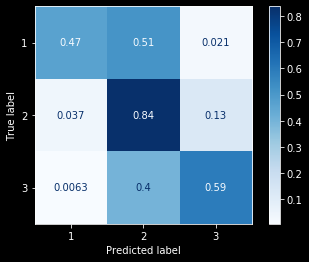

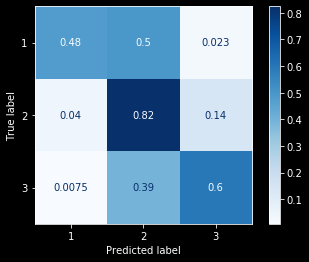

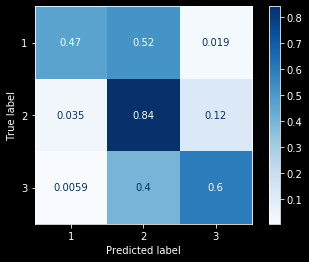

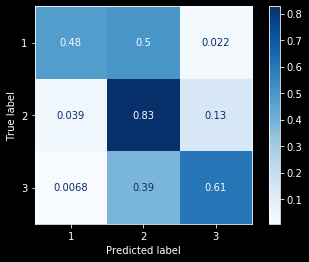

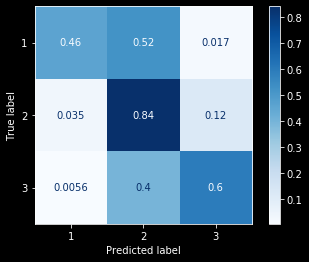

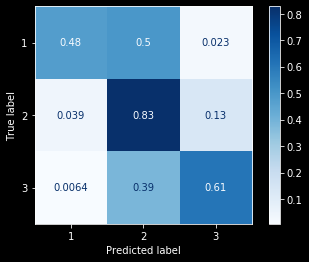

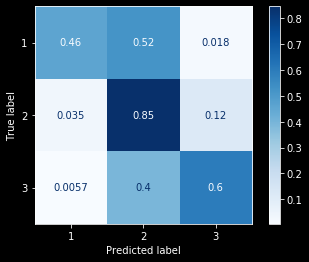

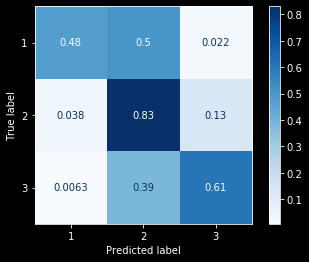

In [9]:
for tuple_item in learner.scored_classifiers:
    plot = learner.plot_confusion_matrix(classifier=tuple_item[2])
plt.show()

In [10]:
for tuple_item in learner.scored_classifiers:
    predicted_output = learner.test_model(classifier=tuple_item[2], file_num=tuple_item[0]+tuple_item[1])

True
True
True
True
True
True
True
True


## Train for normalized data then predict the test values

In [11]:
del learner
gc.collect()

20

In [12]:
learner = Learner(classes=classes, num_estimators=n_estimators, max_depths=max_depths, train_df=train_norm_df, test_df=test_norm_df, submission_df=submission_df)


In [13]:
learner.train_model()

In [14]:
for report in learner.classification_reports:
    print(report)
    print()
    print("*" * 90)
    print()

precision    recall  f1-score       support
1              0.652378  0.461375  0.540498   7521.000000
2              0.720252  0.834507  0.773182  44449.000000
3              0.727085  0.592576  0.652975  26211.000000
accuracy       0.717502  0.717502  0.717502      0.717502
macro avg      0.699905  0.629486  0.655552  78181.000000
weighted avg   0.716014  0.717502  0.710497  78181.000000

******************************************************************************************

              precision    recall  f1-score       support
1              0.629501  0.481186  0.545441   7521.000000
2              0.720586  0.821211  0.767615  44449.000000
3              0.715558  0.594483  0.649426  26211.000000
accuracy       0.712488  0.712488  0.712488      0.712488
macro avg      0.688548  0.632293  0.654160  78181.000000
weighted avg   0.710138  0.712488  0.706618  78181.000000

******************************************************************************************

              pr

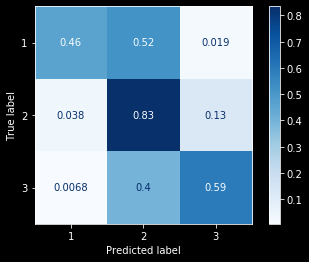

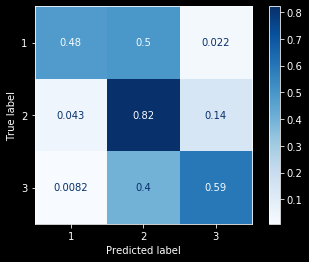

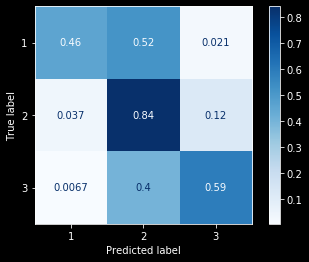

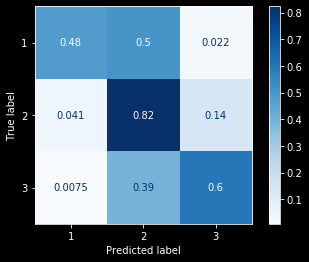

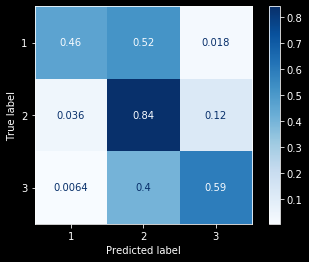

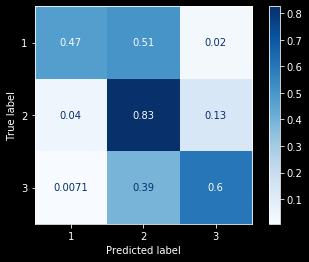

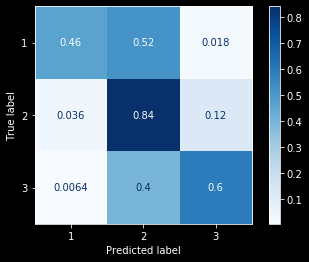

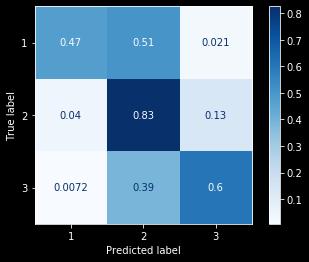

In [15]:
for tuple_item in learner.scored_classifiers:
    plot = learner.plot_confusion_matrix(classifier=tuple_item[2])
plt.show()

In [16]:
for tuple_item in learner.scored_classifiers:
    predicted_output = learner.test_model(classifier=tuple_item[2], file_num=tuple_item[0]+tuple_item[1], obj=False)

True
True
True
True
True
True
True
True


In [17]:
learner.f1_score

[0.717501694785178,
 0.7124876888246504,
 0.7195610186618232,
 0.7149179468157225,
 0.7203412593852726,
 0.7165295915887492,
 0.7230273340069838,
 0.7170668065130913]